In [1]:
import datetime as dt

import dask
import dask.dataframe
import dask.array as da
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from wasserstand.config import DATAFILE_TEMPLATE
from wasserstand.dataset import load_data, build_time_series

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37967,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.53 GiB
Comm: tcp://192.168.1.6:42479,Total threads: 1
Dashboard: http://192.168.1.6:46215/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:39735,


In [3]:
train = build_time_series(load_data(dt.datetime(2021, 10, 23).strftime(DATAFILE_TEMPLATE))).sel(station='Innsbruck')
train = train.diff('time')
train = train.persist()
train

<xarray.DataArray 'transpose-da4ce97fca85deb7f6f37bdd9368e86c' (time: 95)>
dask.array<sub, shape=(95,), dtype=float64, chunksize=(95,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-10-23T00:15:00 ... 2021-10-23T23:45:00
    station  <U32 'Innsbruck'

In [4]:
test = build_time_series(load_data(dt.datetime(2021, 10, 24).strftime(DATAFILE_TEMPLATE))).sel(station='Innsbruck')
test = test.diff('time')
test = test.persist()
test

<xarray.DataArray 'transpose-a9bb22d31027b67e287a4b7bb721e790' (time: 95)>
dask.array<sub, shape=(95,), dtype=float64, chunksize=(95,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-10-24T00:15:00 ... 2021-10-24T23:45:00
    station  <U32 'Innsbruck'

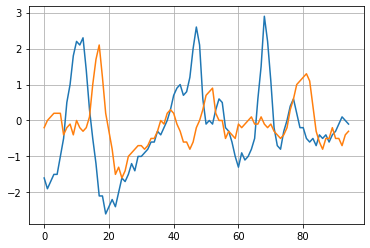

In [5]:
plt.plot(train)
plt.plot(test)
plt.grid()

In [6]:
model_order = 50

coefs = np.zeros(( model_order, 1)) #* 0.9029
learning_rate = 1e-3

x = train.rolling(time=model_order).construct(time='x_win')[model_order:-1].data.persist()
y = train[model_order+1:].data.reshape(-1, 1).persist()

x_test = test.rolling(time=model_order).construct(time='x_win')[model_order:-1].data.persist()
y_test = test[model_order+1:].data.reshape(-1, 1).persist()

xx = (x.T @ x).persist()
xy = (x.T @ y).persist()

In [7]:
def gradient(coefs):    
    return xx @ coefs - xy

def error(coefs, x, y):
    r = y - x @ coefs
    return (r**2).sum()

''

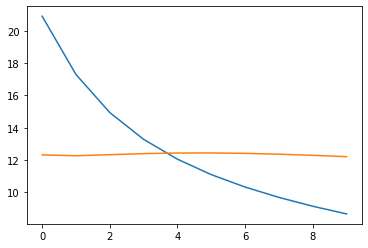

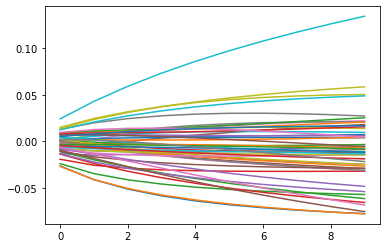

In [8]:
err = []
err_test = []
cs = []
for _ in range(10):
    grad = gradient(coefs).compute()
    coefs = (coefs - grad * learning_rate)
    
    cs.append(coefs.ravel())    
    err.append(error(coefs, x, y))
    err_test.append(error(coefs, x_test, y_test))


plt.plot(err)
plt.plot(err_test)

plt.figure()
plt.plot(cs)
;